<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/sdss_2pcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will guide you through a realistic analysis of galaxy survey data.
We will download real data and then measure its 2-point correlation function.
We will make a theoretical prediction of the 2-point correlaiton function and compare with that of the observation.

In [1]:
import scipy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

Install CAMB for theory prediction \\
Install KSTAT for making measurement

In [2]:
!pip install camb
!git clone https://github.com/csabiu/kstat.git

     |████████████████████████████████| 1.6 MB 31.7 MB/s 
  Created wheel for camb: filename=camb-1.3.2-py3-none-any.whl size=1009274 sha256=4ceb2bb73a0081861695f6ad36772f1a0cd50168d0e74770379ae794555c2838
  Stored in directory: /root/.cache/pip/wheels/d3/c1/34/87632240be4218d112bc9b47c18e92ef81bfb6bc1e1f0f0a72
Successfully built camb
Cloning into 'kstat'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 34 (delta 0), reused 1 (delta 0), pack-reused 30
Unpacking objects: 100% (34/34), done.


Make KSTAT manually

In [3]:
output = os.system("cd kstat/src; make ; cd ../../")

### Download SDSS eBOSS DR12 CMASS data and random catalogs
search in https://data.sdss.org/sas/ for other catalogues if you want to try a different target eg, ELG, QSO

In [4]:
!wget https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz
!wget https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz

--2021-10-28 00:09:50--  https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51580500 (49M) [application/octet-stream]
Saving to: ‘galaxy_DR12v5_CMASS_South.fits.gz’

galaxy_DR12v5_CMASS 100%[===================>]  49.19M  24.2MB/s    in 2.0s    

2021-10-28 00:09:53 (24.2 MB/s) - ‘galaxy_DR12v5_CMASS_South.fits.gz’ saved [51580500/51580500]

--2021-10-28 00:09:53--  https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1172229517 (1.1G) [application/octet-stream]
Saving to: ‘random0_DR12v5_CMASS_South.fits.gz’

random0_DR12v5_CM

### Extract relavent columns from the fits file
Angular positions (RA, dec), redshift (z) and weights

In [5]:
hdul = fits.open('galaxy_DR12v5_CMASS_South.fits.gz')
ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wtot=hdul[1].data['WEIGHT_SYSTOT']
wcp=hdul[1].data['WEIGHT_CP']
wnoz=hdul[1].data['WEIGHT_NOZ']
wfkp=hdul[1].data['WEIGHT_FKP']
wgal=wtot*wfkp*(wcp+wnoz-1.0) #Eq 2 from https://arxiv.org/pdf/1607.03154.pdf



### Plot the redshift distribution

mean redshift of the galaxies : 0.5426714


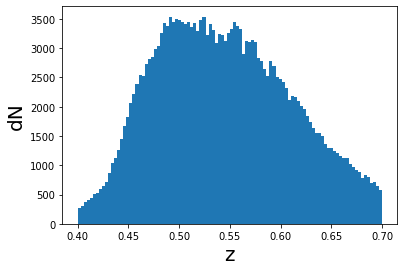

In [8]:
ind=np.where((z>0.4) & (z<0.7)) #cut the redshift range
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the galaxies :",np.mean(z))

Text(0, 0.5, 'dec')

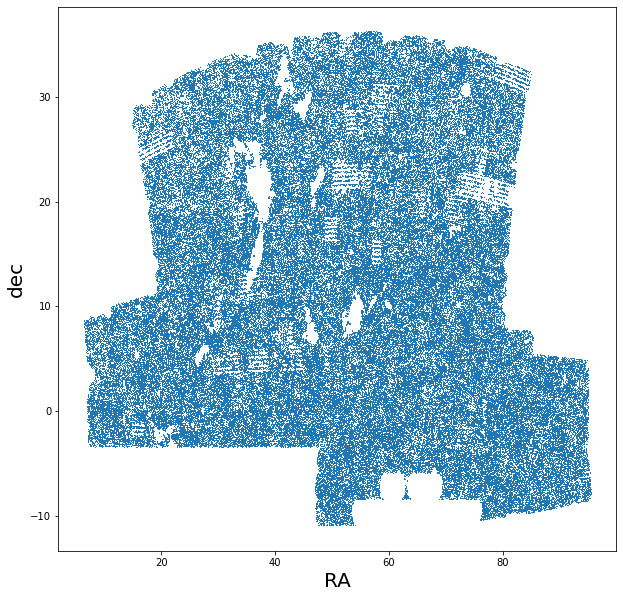

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra+50,360),dec,',')
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

## Use astropy to convert from angle and redshift to cartesean comoving x,y,z positions

In [10]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord

ind=np.where((z>0.4) & (z<0.7))
cosmo=FlatLambdaCDM(Om0=0.31,Ob0=0.022,H0=100) # sets the cosmological model working in units Mpc/h with Ho=100
dist=cosmo.comoving_distance(z[ind]).value  # convert redshift to distance

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc) # convert to x,y,z
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z, wgal[ind]))
np.savetxt("gal.txt",data) # save file 

### Load the Random Catalogue and repeat the same proceedure 

In [11]:
hdul = fits.open('random0_DR12v5_CMASS_South.fits.gz')
ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wrand=hdul[1].data['WEIGHT_FKP']

mean redshift of the randoms : 0.5433296495801546


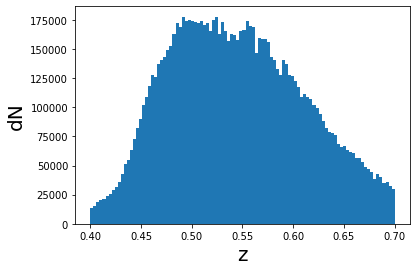

In [12]:
ind=np.where((z>0.4) & (z<0.7))
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the randoms :",np.mean(z))

Plotting the random point angular positions we see that they look almostly exactly like the galaxies as they should

Text(0, 0.5, 'dec')

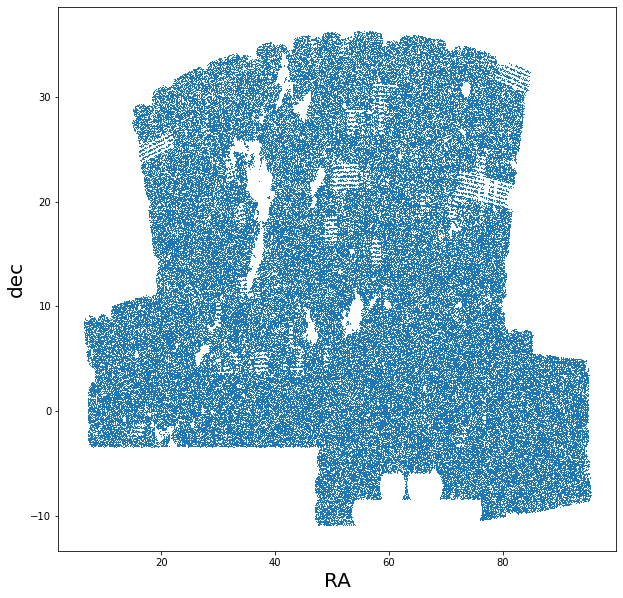

In [13]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra[::50]+50,360),dec[::50],',') # plot a random sample 1/50
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

In [14]:
dist=cosmo.comoving_distance(z[ind]).value

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc)
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z, wrand[ind]))
np.savetxt("ran.txt",data[::50,:]) # save a subsample of data (1/50)

## Run my KSTAT code (~1 min)
20 measurement bins logarithmically spaced between 1 and 60 Mpc

In [15]:
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 1.0 -rmax 60.0 -nbins 20 -log .true. -wgt .true. 

 Using logarithmic binning scheme
 Using weighted points.
 Preparing to read       213205 data points
 Preparing to read       214868 random points
 opening gal.txt
 Finished reading data file 1
 opening ran.txt
 Finished reading data file 2
  building tree on node           0
  built tree on node           0
 Calculating the isotropic 3D correlation function
   1.0000000000000000        1.2271780044536826     
   1.2271780044536826        1.5059658546149226     
   1.5059658546149226        1.8480881722417255     
   1.8480881722417255        2.2679331552660544     
   2.2679331552660544        2.7831576837137404     
   2.7831576837137404        3.4154298923797612     
   3.4154298923797612        4.1913404396820519     
   4.1913404396820519        5.1435207967550411     
   5.1435207967550411        6.3120155872278669     
   6.3120155872278669        7.7459666924148340     
   7.7459666924148340        9.5056799481623280     
   9.5056799481623280        11.665161349761229     
  

Load and plot the result file

In [17]:
!head -1 result.txt # the columns of the result file 

R_min, R_max, DD, DR, RR, XI_natural, XI_Davis, XI_LS (most accurate)


Text(0, 0.5, '$\\xi$')

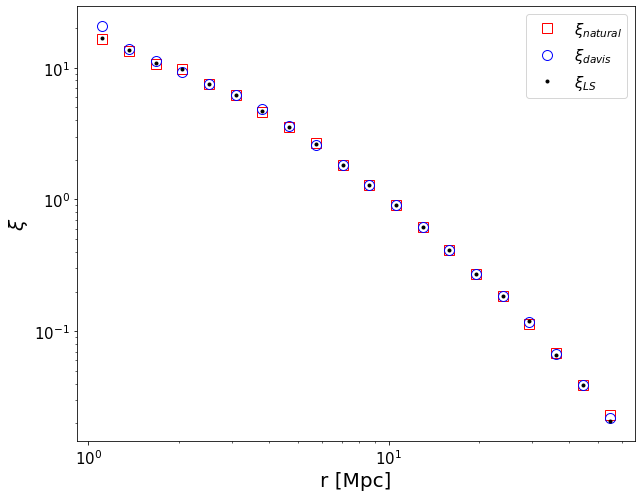

In [40]:
x=np.loadtxt('result.txt',skiprows=1)

xi_natural=x[:,5]
xi_davis=x[:,6]
xi_LS=x[:,7]
s=np.mean(x[:,0:2],axis=1)

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(10,8))
plt.loglog(s,xi_natural,'rs',markerfacecolor='none', ms=10,label=r'$\xi_{natural}$')
plt.loglog(s,xi_davis,'bo',markerfacecolor='none', ms=10,label=r'$\xi_{davis}$')
plt.loglog(s,xi_LS,'k.',label=r'$\xi_{LS}$')

plt.legend()
plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

### Lets start to make the theory prediction with CAMB

In [32]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /usr/local/lib/python3.7/dist-packages/camb


### This is how you set up an instance of CAMB for the matter power spectrum with a particular cosmology 

In [33]:
kmax=100          # maximum k range
k_per_logint = 5  # number of points per loh interval
zs = [0.55]        # redshift (mean of the galaxy sample) 

pars = camb.CAMBparams()
pars.set_cosmology(H0=68.0, ombh2=0.022, omch2=0.12) 
pars.InitPower.set_params(ns=0.965,As=2.0905e-09)
pars.WantTransfer = True
pars.set_matter_power(redshifts=zs, kmax=kmax, k_per_logint=k_per_logint, silent=True)
results = camb.get_results(pars)


PKint = results.get_matter_power_interpolator(nonlinear=True, 
    hubble_units=True, k_hunit=True)

### Lets plot the power spectrum

Text(0, 0.5, '$P(k)$')

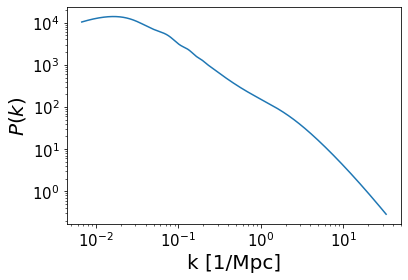

In [34]:
kh_nonlin=np.exp(np.arange(-5.0,3.5,0.0005))
pk_nonlin=PKint.P(0.55, kh_nonlin)
plt.loglog(kh_nonlin,pk_nonlin,'-')

plt.xlabel('k [1/Mpc]',fontsize=20)
plt.ylabel(r'$P(k)$',fontsize=20)

Need to numerically integrate $$ \xi(r)=\frac{1}{2\pi^2}\int k^2P(k) J_0 dk$$

use trapz function to numerically integrate over the integrand which is just product of 1-D arrays - for smooth integrands with enough samples trapz is usually accurate enough

In [45]:
bias=2.2 #galaxy bias parameter

xi=[] 

rr=np.arange(1,60,2) 
for r in rr:
    xi.append(bias**2*np.trapz(kh_nonlin**2*pk_nonlin*np.sin(kh_nonlin*r)/(kh_nonlin*r),kh_nonlin)/(2*np.pi**2) )

Text(0, 0.5, '$\\xi$')

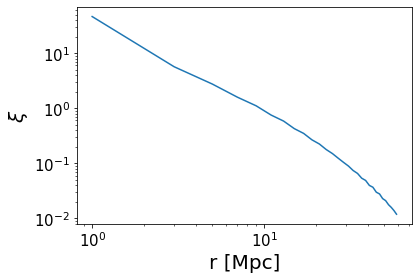

In [46]:
plt.loglog(rr,xi)

plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

### Plot the theory and data together

Text(0, 0.5, '$\\xi$')

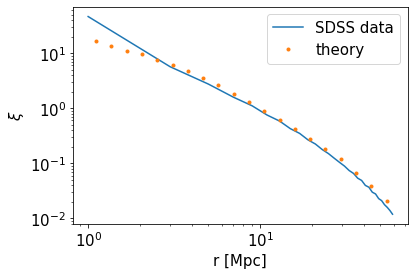

In [49]:
plt.loglog(rr,xi,'-',label='SDSS data')
plt.loglog(s,xi_LS,'.',label='theory')

plt.legend()
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi$')

### Run KSTAT with the anisotropic options (~2 mins)

In [53]:
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 1.0 -rmax 60.0 -nbins 20 -wgt .true. -iso ANISO -decp SIGPI

 Using weighted points.
 Preparing to read       213205 data points
 Preparing to read       214868 random points
 opening gal.txt
 Finished reading data file 1
 opening ran.txt
 Finished reading data file 2
  building tree on node           0
  built tree on node           0
 Calculating the anisotropic correlation function decomposed into sigma-pi
   1.0000000000000000        3.9500000000000002     
   3.9500000000000002        6.9000000000000004     
   6.9000000000000004        9.8500000000000014     
   9.8500000000000014        12.800000000000001     
   12.800000000000001        15.750000000000000     
   15.750000000000000        18.700000000000003     
   18.700000000000003        21.650000000000002     
   21.650000000000002        24.600000000000001     
   24.600000000000001        27.550000000000001     
   27.550000000000001        30.500000000000000     
   30.500000000000000        33.450000000000003     
   33.450000000000003        36.400000000000006     
   36.400000

Load the result file and rearrange and plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'color'
  


Text(0, 0.5, '$\\pi$ [Mpc/h]')

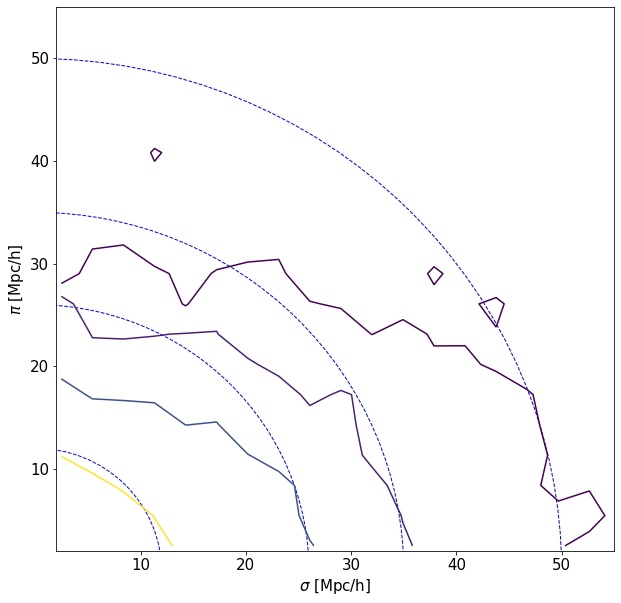

In [80]:
x=np.loadtxt("result.txt",skiprows=1)
sig=np.mean(x[:,0:2],axis=1).reshape((20,20))
pi=np.mean(x[:,2:4],axis=1).reshape((20,20))
xi=x[:,9].reshape((20,20)).transpose()

plt.figure(figsize=(10,10))

plt.contour(pi,sig,xi,levels=[0.04,0.1,0.2,0.7],color='k')
plt.xlim((2,55))
plt.ylim((2,55))

circ1=plt.Circle((0,0),12,color='b', fill=False,linestyle='--')
circ2=plt.Circle((0,0),26,color='b', fill=False,linestyle='--')
circ3=plt.Circle((0,0),35,color='b', fill=False,linestyle='--')
circ4=plt.Circle((0,0),50,color='b', fill=False,linestyle='--')

ax = plt.gca()
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)
plt.xlabel(r'$\sigma$ [Mpc/h]')
plt.ylabel(r'$\pi$ [Mpc/h]')

### Anisotropic Analysis
Use the kaiser formula \\
$$ P^s_g(k,\mu)= P^r_m(k)( b_g +f\mu^2)^2$$

In [81]:
ff=1.1   # growth
bias=1.5 # galaxy bias

pk_ani=np.zeros((60,60))

for i in range(1,60):    #1->60 Mpc sigma-pi
  for j in range(1,60):
    rr=np.sqrt(i**2+j**2)
    mu=j/rr
    pk=pk_nonlin*(bias+ff*mu**2)**2
    pk_ani[i,j]=np.trapz(kh_nonlin**2*pk*np.sin(kh_nonlin*rr)/(kh_nonlin*rr),kh_nonlin)/(2*np.pi**2)

Plot the anisotropic theory

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, '$\\pi$ [Mpc/h]')

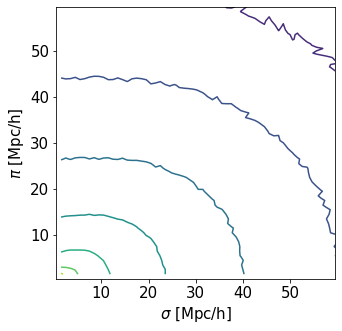

In [82]:
plt.figure(figsize=(5,5))
plt.contour(np.log10(pk_ani),origin='lower')
plt.xlabel(r'$\sigma$ [Mpc/h]')
plt.ylabel(r'$\pi$ [Mpc/h]')

### Plot the theory and data together

Text(0, 0.5, '$\\pi$ [Mpc/h]')

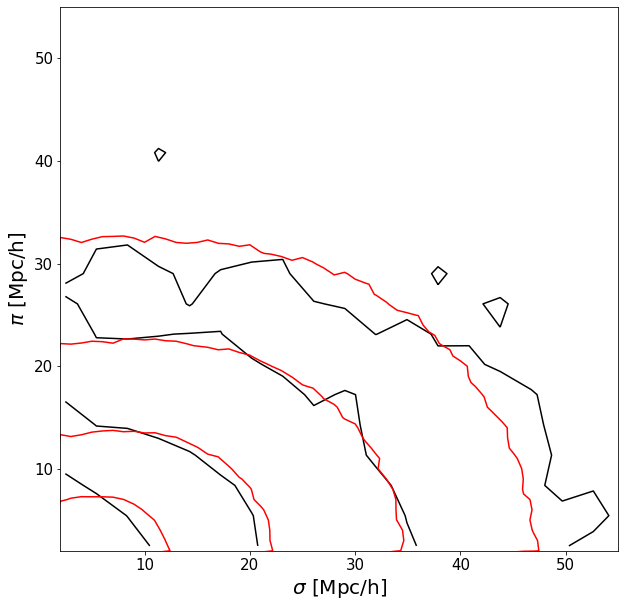

In [83]:
plt.figure(figsize=(10,10))
plt.contour(pi,sig,(xi),levels=[0.04, 0.1,0.3,1], colors='k')
plt.contour(range(1,61),range(1,61),(pk_ani),levels=[0.04, 0.1,0.3,1], colors='r')
plt.xlim((2,55))
plt.ylim((2,55))
plt.xlabel(r'$\sigma$ [Mpc/h]',fontsize=20)
plt.ylabel(r'$\pi$ [Mpc/h]',fontsize=20)

Adding the Alcock Paczynski Effect \\
$$\xi(\sigma,\pi) = \xi(\alpha_{\perp}\sigma_{fid},\alpha_{\parallel}\pi_{fid})$$ \\
$$\alpha_{\perp} $$

In [305]:
ff=0.7       # growth
bias=1.8     # galaxy bias
alphapi=1.05
alphasigma=1.00

pk_ani2=np.zeros((60,60))

for i in range(1,60):    #1->60 Mpc sigma-pi
  for j in range(1,60):
    rr=np.sqrt((i*alphasigma)**2+(j*alphapi)**2)
    mu=(j*alphapi)/rr
    pk=pk_nonlin*(bias+ff*mu**2)**2
    pk_ani2[i,j]=np.trapz(kh_nonlin**2*pk*np.sin(kh_nonlin*rr)/(kh_nonlin*rr),kh_nonlin)/(2*np.pi**2)

Text(0, 0.5, '$\\pi$ [Mpc/h]')

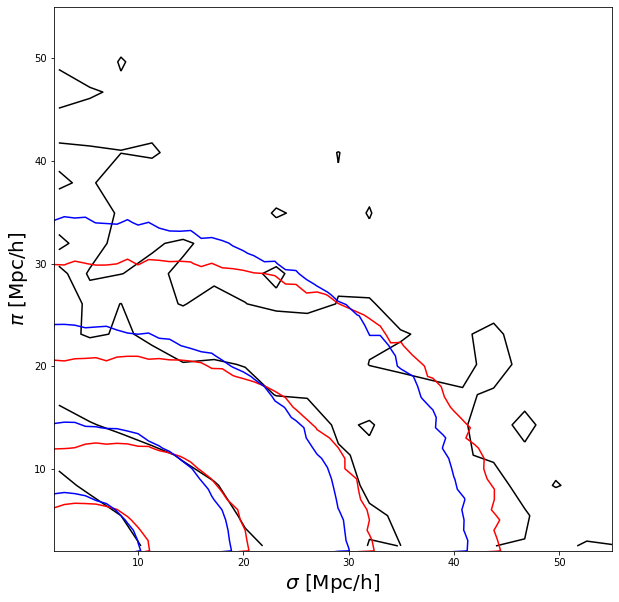

In [306]:
plt.figure(figsize=(10,10))
plt.contour(pi,sig,(xi),levels=[0.04, 0.1,0.3,1], colors='k')
plt.contour(range(1,61),range(1,61),(pk_ani),levels=[0.04, 0.1,0.3,1], colors='r')
plt.contour(range(1,61),range(1,61),(pk_ani2),levels=[0.04, 0.1,0.3,1], colors='b')
plt.xlim((2,55))
plt.ylim((2,55))
plt.xlabel(r'$\sigma$ [Mpc/h]',fontsize=20)
plt.ylabel(r'$\pi$ [Mpc/h]',fontsize=20)

Large Scale and BAO

In [4]:
#np.savetxt("ran.txt",data[::30,:]) # save a subsample of random data (1/30)
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 50.0 -rmax 125.0 -nbins 15 -wgt .true. 

/bin/bash: kstat/bin/2pcf: No such file or directory


In [402]:
bias=2.2 #galaxy bias parameter

xi=[]
#rr=np.arange(10,200,10)
rr=np.arange(50,150,2)
for r in rr:
    xi.append(bias**2*np.trapz(kh_nonlin**2*pk_nonlin*np.sin(kh_nonlin*r)/(kh_nonlin*r),kh_nonlin)/(2*np.pi**2) )

In [1]:
x=np.loadtxt('result.txt',skiprows=1)
r=np.mean(x[:,0:2],axis=1)
plt.errorbar(r,x[:,7]*r**2,'.')
plt.plot(rr,xi*rr**2,'-')
plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)


NameError: ignored

In [ ]:
x=np.loadtxt("result.txt",skiprows=1)
plt.plot(rr,xi*rr*rr,'-')
plt.errorbar(np.mean(x[:,0:1],axis=1),x[:,7]*np.mean(x[:,0:1],axis=1)**2,yerr=0.1*x[:,7]*np.mean(x[:,0:1],axis=1)**2,marker='.',ls='none')

plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

In [342]:
ls

eBOSS_LRG_clustering_data-NGC-vDR16.fits
eBOSS_LRG_clustering_data-NGC-vDR16.fits.1
eBOSS_LRG_clustering_random-NGC-vDR16.fits
eBOSS_LRG_clustering_random-NGC-vDR16.fits.1
galaxy_DR12v5_CMASS_North.fits.gz
galaxy_DR12v5_CMASS_South.fits.gz
gal.txt
kstat/
random0_DR12v5_CMASS_North.fits.gz
random0_DR12v5_CMASS_South.fits.gz
ran_shuf.txt
ran.txt
result.txt
sample_data/
